In [90]:
from PIL import Image
%matplotlib inline
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
import torch

from copy import deepcopy
from ec.config import DEFAULT_CONFIG
from ec.models import EdgeModel, InpaintingModel
from pconv.util import ImageChunker
from pycocotools.coco import COCO
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import canny
from skimage.color import rgb2gray, gray2rgb

In [91]:
data_dir = '../data'
data_type = 'val2017'
model_dir = '../models/base_edge_connect_psv'

In [92]:
coco = COCO('{}/raw/annotations/instances_{}.json'.format(data_dir, data_type))
category_ids = coco.getCatIds(supNms=['person', 'vehicle'])

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!


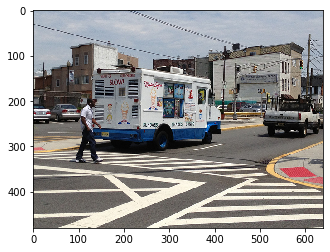

In [93]:
image_id = 393226
image_info = coco.loadImgs([image_id])[0]
image = imread('{}/raw/images/{}/{}'.format(data_dir, data_type, image_info['file_name']))
plt.imshow(image)

In [94]:
annotation_ids = coco.getAnnIds(imgIds=[image_id], catIds=category_ids)
annotations = coco.loadAnns(annotation_ids)

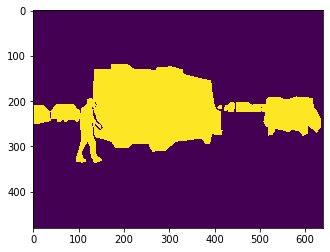

In [95]:
mask = np.zeros(image.shape[:2], dtype='uint8')
for annotation in annotations:
    mask = cv.bitwise_or(mask, coco.annToMask(annotation))
plt.imshow(mask)

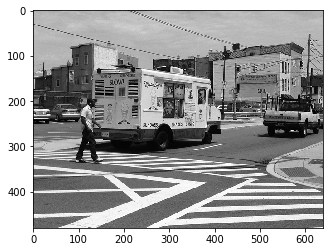

In [96]:
image_gray = rgb2gray(image)
plt.imshow(image_gray, cmap='gray', vmin=0, vmax=1)

In [97]:
class Config(dict):
    def __getattr__(self, name):
        if self.get(name) is not None:
            return self[name]

        if DEFAULT_CONFIG.get(name) is not None:
            return DEFAULT_CONFIG[name]

        return None

config = Config()
config['PATH'] = model_dir

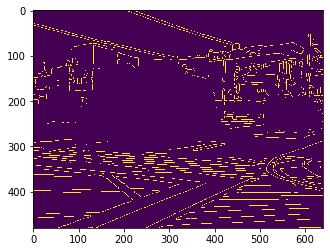

In [98]:
inverted_mask = (np.ones(mask.shape) - mask).astype(np.bool)
edge = canny(image_gray, sigma=config.SIGMA, mask=inverted_mask).astype(np.float)
plt.imshow(edge)

In [99]:
class EdgeConnect:
    def __init__(self, config):
        self.config = config
        self.edge_model = EdgeModel(config).to(config.DEVICE)
        self.inpainting_model = InpaintingModel(config).to(config.DEVICE)
        self.edge_model.load()
        self.inpainting_model.load()
    
    def predict(self, x):
        images, masks, images_gray, edges = self.cuda(*x)
        edges = self.edge_model(images_gray, edges, masks).detach()
        outputs = self.inpainting_model(images, edges, masks)
        outputs_merged = (outputs * masks) + (images * (1 - masks))

        output = self.postprocess(outputs_merged)[0]
        return output

    def cuda(self, *args):
        return (item.to(self.config.DEVICE) for item in args)
    
    def postprocess(self, img):
        # [0, 1] => [0, 255]
        img = img * 255.0
        img = img.permute(0, 2, 3, 1)
        return img.int()

model = EdgeConnect(config)

Loading EdgeModel generator...
Loading EdgeModel discriminator...
Loading InpaintingModel generator...
Loading InpaintingModel discriminator...


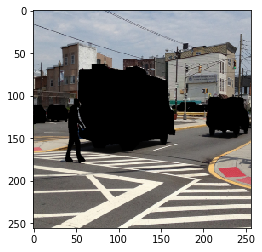

In [100]:
def prepare(img):
    img_p = resize(img, (config.INPUT_SIZE, config.INPUT_SIZE))
    if len(img.shape) == 2:
        return img_p.reshape((config.INPUT_SIZE, config.INPUT_SIZE, 1))
    else:
        return img_p
        

def to_tensor(img):
    img = prepare(img)
    img_t = F.to_tensor(img).float()
    s = img_t.shape
    return img_t.reshape((1, s[0], s[1], s[2]))

blabla = image
blabla[mask==1] = 0.0
blabla_gray = image_gray
blabla_gray[mask==1] = 0.0
image_t, mask_t, image_gray_t, edge_t = to_tensor(blabla), to_tensor(mask * 255), \
                                    to_tensor(blabla_gray), to_tensor(edge)

plt.imshow(mask_t.reshape(256, 256))
plt.imshow(edge_t.reshape(256, 256))
plt.imshow(image_gray_t.reshape(256, 256))
plt.imshow(image_t.permute(2, 3, 1, 0).reshape(256, 256, 3))

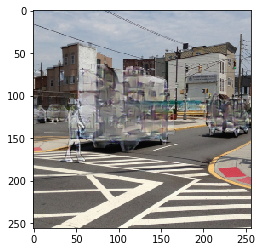

In [101]:
output = model.predict([image_t, mask_t, image_gray_t, edge_t])
plt.imshow(output)

In [102]:
# TODO edge-connect inpainting for any picture size
# chunker = ImageChunker(config.INPUT_SIZE, config.INPUT_SIZE, 30)
# 
# def plot_images(images, s=5):
#     _, axes = plt.subplots(1, len(images), figsize=(s*len(images), s))
#     if len(images) == 1:
#         axes = [axes]
#     for img, ax in zip(images, axes):
#         ax.imshow(img)
#     plt.show()
# 
# mask = mask.reshape((mask.shape[0], mask.shape[1], 1)).astype(np.float) * 255
# image_gray = image_gray.reshape((image_gray.shape[0], image_gray.shape[1], 1)).astype(np.float)
# edge = edge.reshape((edge.shape[0], edge.shape[1], 1)).astype(np.float)
# 
# 
# chunked_images = torch.tensor(chunker.dimension_preprocess(deepcopy(image))).float()
# chunked_masks = torch.tensor(chunker.dimension_preprocess(deepcopy(mask))).float()
# chunked_images_gray = torch.tensor(chunker.dimension_preprocess(deepcopy(image_gray))).float()
# chunked_edges = torch.tensor(chunker.dimension_preprocess(deepcopy(edge))).float()
# pred_imgs = model.predict([chunked_images, chunked_masks, chunked_images_gray, chunked_edges])
# reconstructed_image = chunker.dimension_postprocess(pred_imgs, image)
# 
# plot_images([image, reconstructed_image], s=10)

RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (3, 3) at dimension 3 of input 4